In [59]:
def alcubierre_shape_function(r): 
    sigma = 1
    R = 5
    f = (((np.tanh(sigma*(r+R)))-(np.tanh(sigma*(r-R))))/(2*np.tanh(sigma*R)))
    return f

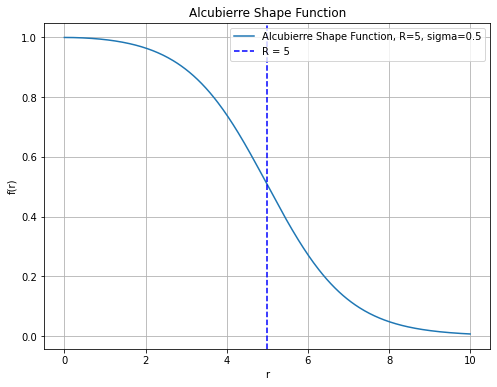

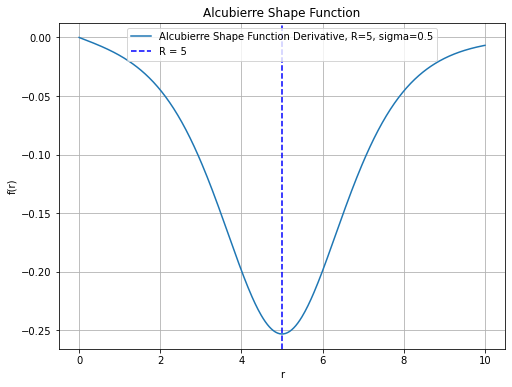

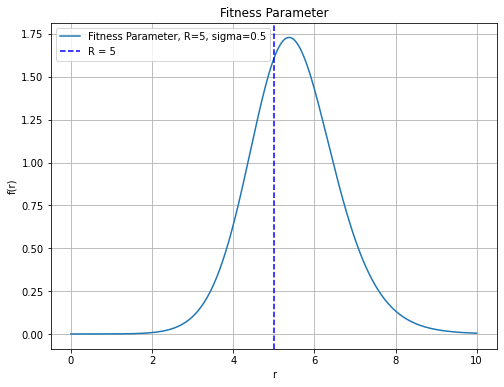

Alcubierre Total Energy Requirement: 4.496030169993188


In [231]:
import numpy as np
import matplotlib.pyplot as plt


sigma = 0.5
R = 5
    
def alcubierre_shape_function(r,R,sigma):
    f = (((np.tanh(sigma*(r+R)))-(np.tanh(sigma*(r-R))))/(2*np.tanh(sigma*R)))
    return f


# Centered finite difference at h = 1e-6

def alcubierre_shape_derivative(r, epsilon=1e-7):
    derivative = ((alcubierre_shape_function(r + epsilon,R,sigma)) - alcubierre_shape_function(r - epsilon,R,sigma)) / (2 * epsilon)
    return derivative


def fitness_parameter(r):
    return  (r**2)*(alcubierre_shape_derivative(r)**2)


# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = alcubierre_shape_function(r_values,R,sigma)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Alcubierre Shape Function, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Alcubierre Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = alcubierre_shape_derivative(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Alcubierre Shape Function Derivative, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Alcubierre Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()





# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = fitness_parameter(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Fitness Parameter, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Fitness Parameter')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



alcubierre_energy_requirement, _ = spi.quad(fitness_parameter, 0, 10)

print("Alcubierre Total Energy Requirement: "+ str(alcubierre_energy_requirement))






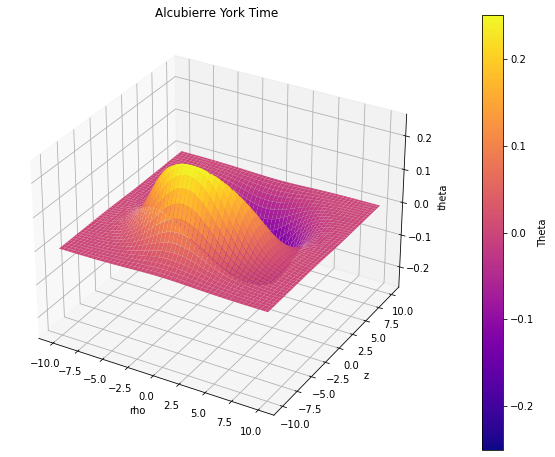

In [223]:
def plot_alcubierre_york_time(rho, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(rho**2 + z**2)
    derivative = (alcubierre_shape_function(r + epsilon, R, sigma) - alcubierre_shape_function(r - epsilon, R, sigma)) / (2 * epsilon)
    theta = (z / r) * derivative
    return theta

# Define the range of rho and z values
rho_vals = np.linspace(-10, 10, 200)
z_vals = np.linspace(-10, 10, 200)
rho_mesh, z_mesh = np.meshgrid(rho_vals, z_vals)

# Calculate theta values for each combination of rho and z
theta_mesh = plot_alcubierre_york_time(rho_mesh, z_mesh)

# Create a larger 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a galaxy-themed color map
galaxy_cmap = plt.get_cmap('plasma')

# Plot the surface with the galaxy-themed color map
surface = ax.plot_surface(rho_mesh, z_mesh, theta_mesh, cmap=galaxy_cmap)

# Set labels for the axes
ax.set_xlabel('rho')
ax.set_ylabel('z')
ax.set_zlabel('theta')

# Set a title for the plot
ax.set_title('Alcubierre York Time')

# Add color bar
cbar = fig.colorbar(surface, ax=ax, pad=0.1)
cbar.set_label('Theta')

# Show the plot
plt.show()

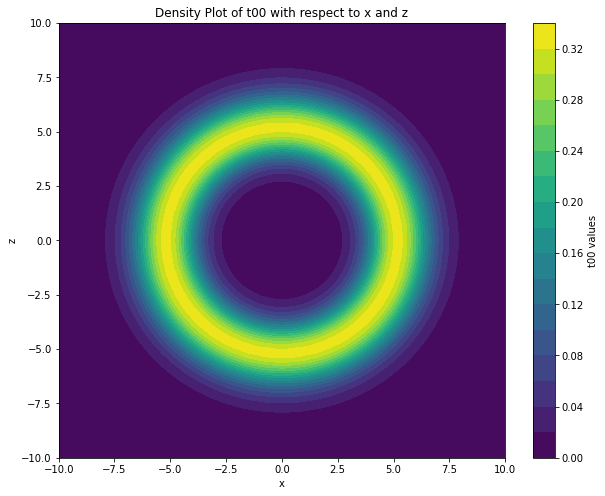

In [225]:
def plot_alcubierre_eulerian_violation(x, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(x**2 + z**2)
    derivative = (alcubierre_shape_function(r + epsilon, R, sigma) - alcubierre_shape_function(r - epsilon, R, sigma)) / (2 * epsilon)
    t00 = r * (derivative**2)
    return t00



# Generate a grid of x and z values
x_vals = np.linspace(-10, 10, 100)
z_vals = np.linspace(-10, 10, 100)
X, Z = np.meshgrid(x_vals, z_vals)

# Calculate the t00 values for each combination of x and z
t00_vals = plot_alcubierre_eulerian_violation(X, Z)

# Create a density plot
plt.figure(figsize=(10, 8))
plt.contourf(X, Z, t00_vals, levels=20, cmap='viridis')
plt.colorbar(label='t00 values')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Density Plot of t00 with respect to x and z')
plt.show()

In [257]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""

# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import deepxde as dde
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import plotly.graph_objects as go
import sympy as sp
import scipy.integrate as spi
from scipy.interpolate import interp1d


def generate_evolution_model(domain, boundary, width, depth, rate, epochs):

    def pde(x, y):
        # y = (f)
        # x = (r,t)
        df_r = dde.grad.jacobian(y, x, i=0, j=0)
        return (x[:,0:1]*(df_r**2))**2

    
    model_frames = []

    main_domain = dde.geometry.Interval(0,10)
    geom = main_domain


    ic = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[0],0),
    )
    
    ic2 = dde.icbc.DirichletBC(
        geom,
        lambda x: 0,
        lambda x, on_boundary:  np.isclose(x[0],10),
    )

#     dic = dde.icbc.OperatorBC(
#     geom,
#     lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
#     lambda _, on_initial: on_initial,)


    data = dde.data.PDE(
        geom, pde, [ic, ic2], num_domain=domain, num_boundary=boundary)


    net = dde.nn.FNN([1] + [width] * depth + [1], "tanh", "Glorot normal")


    model = dde.Model(data, net)
    model.compile("adam", lr=rate)
    for i in range(10):
        model_frames.append(model)
        losshistory, train_state = model.train(iterations=1000)
        model_frames.append(model)
        print("Epoch Batch " + str(i) + " Completed")
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    
    
    print("Training Complete!")

    return model




Compiling model...
Building feed-forward neural network...
'build' took 0.075553 s



C:\Users\Lyle\anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.526188 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.97e-04, 1.00e+00]    [5.97e-04, 1.00e+00]    []  
1000      [1.21e-08, 0.00e+00]    [1.21e-08, 0.00e+00]    []  
2000      [5.37e-09, 1.42e-14]    [5.37e-09, 1.42e-14]    []  
3000      [2.94e-09, 0.00e+00]    [2.94e-09, 0.00e+00]    []  
4000      [1.82e-09, 3.55e-15]    [1.82e-09, 3.55e-15]    []  
5000      [1.40e-09, 0.00e+00]    [1.40e-09, 0.00e+00]    []  

Best model at step 5000:
  train loss: 1.40e-09
  test loss: 1.40e-09
  test metric: []

'train' took 4.608902 s

Saving loss history to C:\Users\Lyle\Desktop\loss.dat ...
Saving training data to C:\Users\Lyle\Desktop\train.dat ...
Saving test data to C:\Users\Lyle\Desktop\test.dat ...


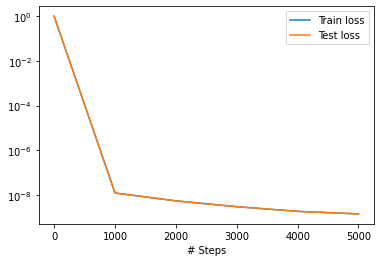

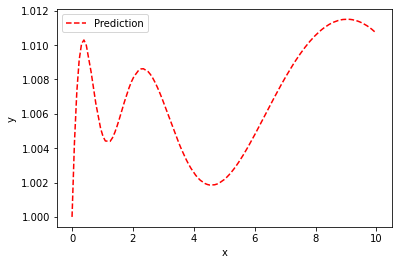

In [169]:
generate_evolution_model(100,100,10,1,0.01,5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.049585 s

'compile' took 0.360256 s

Training model...

Step      Train loss    Test loss     Test metric
0         [7.01e-04]    [7.01e-04]    []  
1000      [1.26e-10]    [1.26e-10]    []  
2000      [8.08e-11]    [8.08e-11]    []  
3000      [5.86e-11]    [5.86e-11]    []  
4000      [4.48e-11]    [4.48e-11]    []  
5000      [3.69e-11]    [3.69e-11]    []  
6000      [3.26e-11]    [3.26e-11]    []  
7000      [2.90e-11]    [2.90e-11]    []  
8000      [2.49e-11]    [2.49e-11]    []  
9000      [2.03e-11]    [2.03e-11]    []  
10000     [1.55e-11]    [1.55e-11]    []  

Best model at step 10000:
  train loss: 1.55e-11
  test loss: 1.55e-11
  test metric: []

'train' took 7.614067 s

Saving loss history to C:\Users\Lyle\Desktop\loss.dat ...
Saving training data to C:\Users\Lyle\Desktop\train.dat ...
Saving test data to C:\Users\Lyle\Desktop\test.dat ...


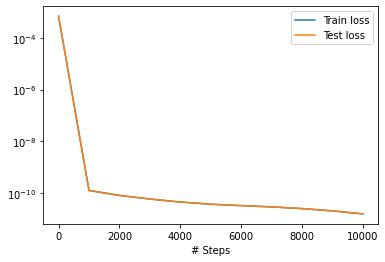

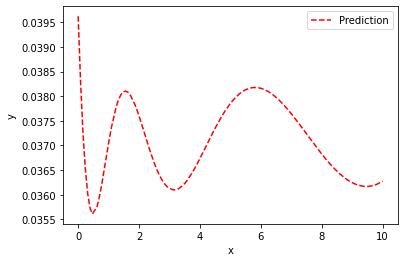

In [115]:
model_1 = generate_evolution_model(100,100,10,1,0.01,10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.035387 s

'compile' took 0.350297 s

Training model...

Step      Train loss    Test loss     Test metric
0         [2.56e-04]    [2.56e-04]    []  
1000      [1.40e-10]    [1.40e-10]    []  
2000      [2.74e-11]    [2.74e-11]    []  
3000      [1.07e-11]    [1.07e-11]    []  
4000      [4.69e-12]    [4.69e-12]    []  
5000      [2.14e-12]    [2.14e-12]    []  
6000      [1.02e-12]    [1.02e-12]    []  
7000      [4.95e-13]    [4.95e-13]    []  
8000      [2.54e-13]    [2.54e-13]    []  
9000      [1.60e-13]    [1.60e-13]    []  
10000     [1.27e-13]    [1.27e-13]    []  

Best model at step 10000:
  train loss: 1.27e-13
  test loss: 1.27e-13
  test metric: []

'train' took 7.504699 s

Saving loss history to C:\Users\Lyle\Desktop\loss.dat ...
Saving training data to C:\Users\Lyle\Desktop\train.dat ...
Saving test data to C:\Users\Lyle\Desktop\test.dat ...


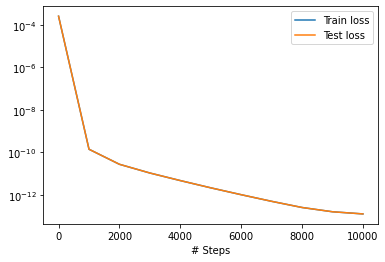

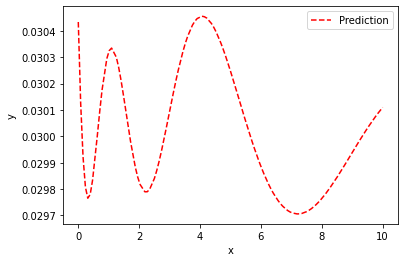

In [125]:
model_0 = generate_evolution_model(100,100,10,1,0.01,10000)

In [126]:
type(model_0)

deepxde.model.Model

In [ ]:
def calculate_model_fitness_parameter(model):
    r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
    r_values = [[value] for value in r_values]

    f_values = model.predict(r_values)
    f_values.flatten()
    
    
    

    def model_fitness_parameter(r):
        return  r*(alcubierre_shape_derivative(r)**2)

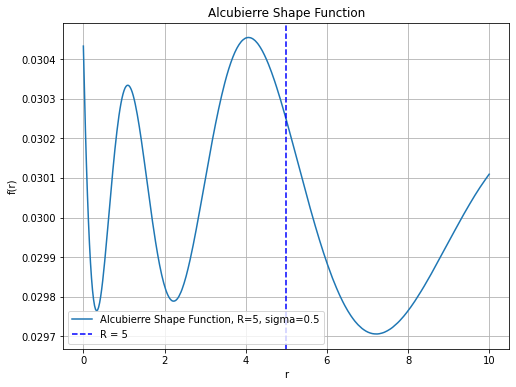

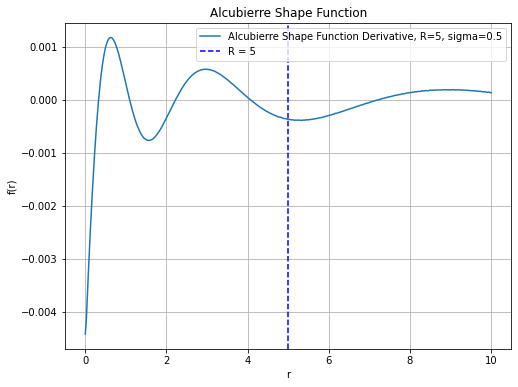

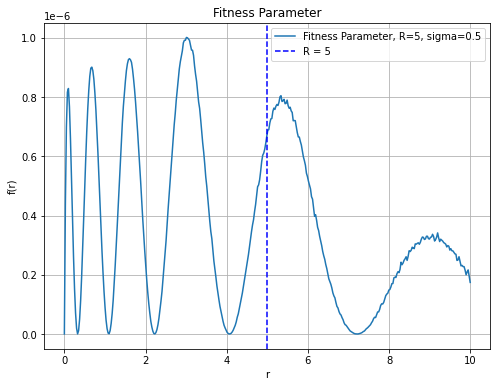

Model Total Energy Energy: 3.7162478652928383e-06
Relative Percent Difference from Alcubierre: 0.00043463328653416545%


C:\Users\Lyle\AppData\Local\Temp\ipykernel_7680\3718356343.py:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)


In [167]:


# Your existing code
r_values = np.linspace(0, 10, 400)
f_values = model_0.predict(r_values.reshape(-1, 1)).flatten()

# Create an interpolation function
model_shape_function = interp1d(r_values, f_values, kind='linear', fill_value="extrapolate")


def model_shape_derivative(r):
    epsilon = 1e-7
    derivative = ((model_shape_function(r + epsilon)) - model_shape_function(r - epsilon)) / (2 * epsilon)
    return derivative


def model_fitness_parameter(r):
    return  r*(model_shape_derivative(r)**2)




# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Alcubierre Shape Function, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Alcubierre Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_shape_derivative(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Alcubierre Shape Function Derivative, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Alcubierre Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_fitness_parameter(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Fitness Parameter, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Fitness Parameter')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()


model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)

print("Model Total Energy Energy: " + str(model_energy_requirement))
print("Relative Percent Difference from Alcubierre: " + str((model_energy_requirement/alcubierre_energy_requirement)*100) + "%")



Compiling model...
Building feed-forward neural network...
'build' took 0.053964 s

'compile' took 0.582599 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.63e-05, 1.00e+00]    [1.63e-05, 1.00e+00]    []  
1000      [2.45e-09, 1.42e-14]    [2.45e-09, 1.42e-14]    []  
2000      [1.32e-09, 1.42e-14]    [1.32e-09, 1.42e-14]    []  
3000      [1.16e-09, 3.55e-15]    [1.16e-09, 3.55e-15]    []  
4000      [1.09e-09, 3.20e-14]    [1.09e-09, 3.20e-14]    []  
5000      [9.92e-10, 5.68e-14]    [9.92e-10, 5.68e-14]    []  

Best model at step 5000:
  train loss: 9.92e-10
  test loss: 9.92e-10
  test metric: []

'train' took 4.778834 s

Saving loss history to C:\Users\Lyle\Desktop\loss.dat ...
Saving training data to C:\Users\Lyle\Desktop\train.dat ...
Saving test data to C:\Users\Lyle\Desktop\test.dat ...


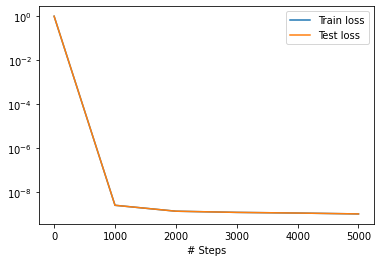

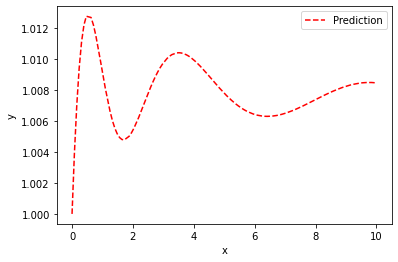

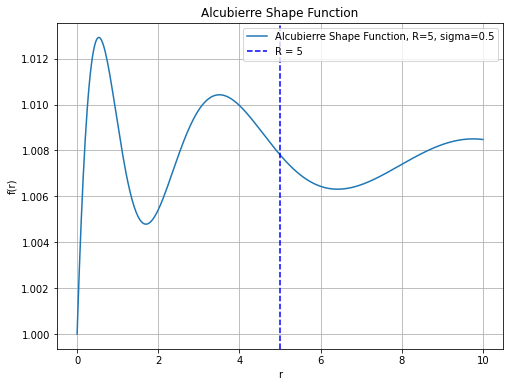

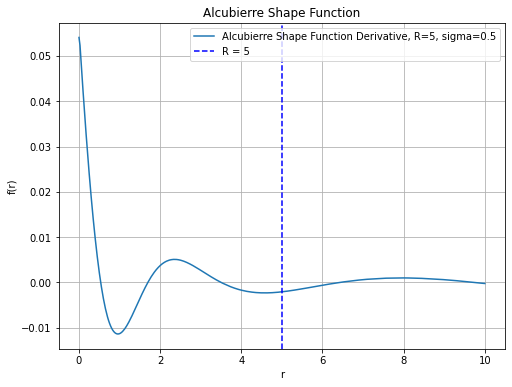

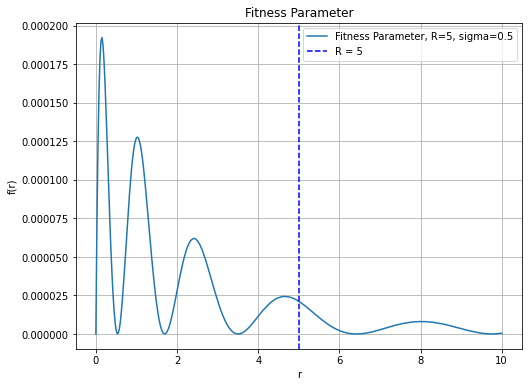

Model Total Energy Energy: 0.000228416410857581
Relative Percent Difference from Alcubierre: 0.02671441167220036%


C:\Users\Lyle\AppData\Local\Temp\ipykernel_7680\125936334.py:72: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)


In [171]:


model_0 = generate_evolution_model(100,100,10,1,0.01,5000)

# Your existing code
r_values = np.linspace(0, 10, 400)
f_values = model_0.predict(r_values.reshape(-1, 1)).flatten()

# Create an interpolation function
model_shape_function = interp1d(r_values, f_values, kind='linear', fill_value="extrapolate")


def model_shape_derivative(r):
    epsilon = 1e-7
    derivative = ((model_shape_function(r + epsilon)) - model_shape_function(r - epsilon)) / (2 * epsilon)
    return derivative


def model_fitness_parameter(r):
    return  r*(model_shape_derivative(r)**2)




# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Alcubierre Shape Function, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Alcubierre Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_shape_derivative(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Alcubierre Shape Function Derivative, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Alcubierre Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_fitness_parameter(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Fitness Parameter, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Fitness Parameter')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()


model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)

print("Model Total Energy Energy: " + str(model_energy_requirement))
print("Relative Percent Difference from Alcubierre: " + str((model_energy_requirement/alcubierre_energy_requirement)*100) + "%")



Compiling model...
Building feed-forward neural network...
'build' took 0.049845 s

'compile' took 0.621173 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.83e-08, 1.00e+00, 4.47e-01]    [4.83e-08, 1.00e+00, 4.47e-01]    []  
1000      [2.53e-05, 1.01e-08, 8.56e-09]    [2.53e-05, 1.01e-08, 8.56e-09]    []  
2000      [7.56e-06, 1.17e-09, 9.73e-10]    [7.56e-06, 1.17e-09, 9.73e-10]    []  
3000      [3.44e-06, 2.73e-10, 2.39e-10]    [3.44e-06, 2.73e-10, 2.39e-10]    []  
4000      [6.85e-06, 1.28e-05, 1.52e-03]    [6.85e-06, 1.28e-05, 1.52e-03]    []  
5000      [3.99e-06, 3.07e-10, 2.29e-10]    [3.99e-06, 3.07e-10, 2.29e-10]    []  
6000      [3.85e-06, 3.24e-08, 4.39e-08]    [3.85e-06, 3.24e-08, 4.39e-08]    []  
7000      [1.30e-06, 7.85e-05, 9.02e-03]    [1.30e-06, 7.85e-05, 9.02e-03]    []  
8000      [3.41e-06, 2.48e-06, 3.99e-06]    [3.41e-06, 2.48e-06, 3.99e-06]    []  
9000      [2.90e-06, 2.90e-09, 2.

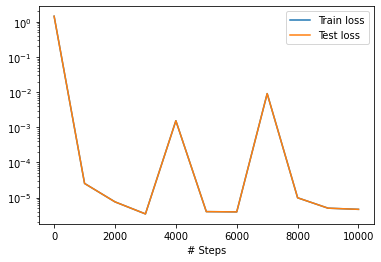

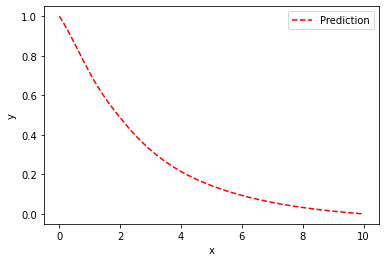

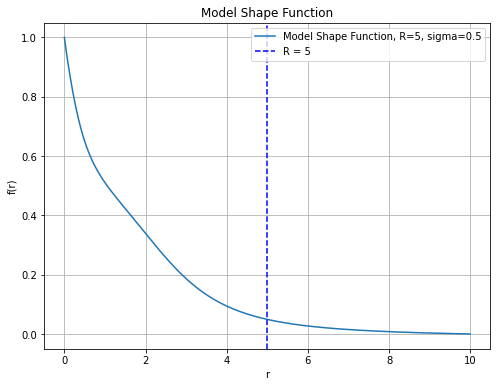

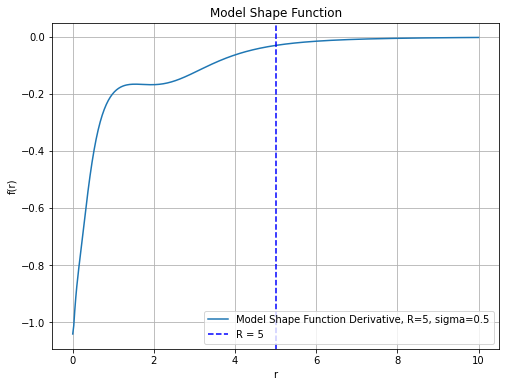

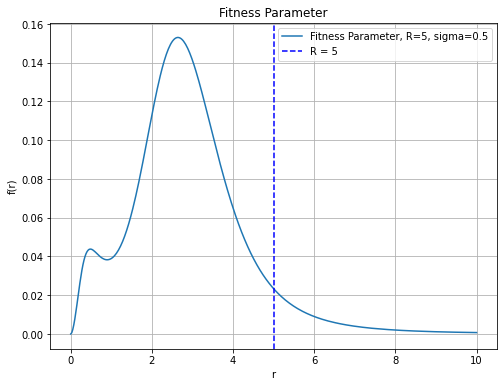

C:\Users\Lyle\AppData\Local\Temp\ipykernel_7680\919593292.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)


Model Total Energy Requirement: 0.412809468369014
Relative Percent Difference from Alcubierre: 9.18164364474537%


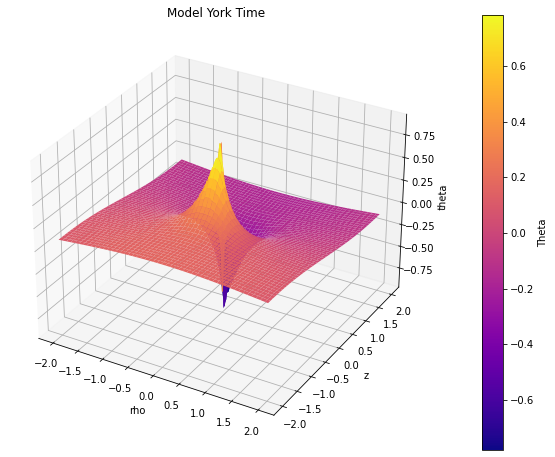

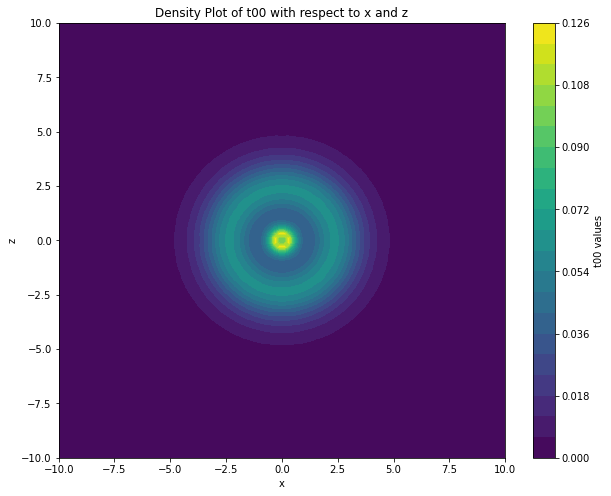

In [232]:


model_0 = generate_evolution_model(100,100,100,2,0.01,10000)

# Your existing code
r_values = np.linspace(0, 10, 400)
f_values = model_0.predict(r_values.reshape(-1, 1)).flatten()

# Create an interpolation function
model_shape_function = interp1d(r_values, f_values, kind='linear', fill_value="extrapolate")


def model_shape_derivative(r):
    epsilon = 1e-7
    derivative = ((model_shape_function(r + epsilon)) - model_shape_function(r - epsilon)) / (2 * epsilon)
    return derivative


def model_fitness_parameter(r):
    return  (r**2)*(model_shape_derivative(r)**2)



# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Model Shape Function, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Model Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_shape_derivative(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Model Shape Function Derivative, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Model Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_fitness_parameter(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Fitness Parameter, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Fitness Parameter')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()




model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)

print("Model Total Energy Requirement: " + str(model_energy_requirement))
print("Relative Percent Difference from Alcubierre: " + str((model_energy_requirement/alcubierre_energy_requirement)*100) + "%")



def plot_alcubierre_york_time(rho, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(rho**2 + z**2)
    derivative = (model_shape_function(r + epsilon) - model_shape_function(r - epsilon)) / (2 * epsilon)
    theta = (z / r) * derivative
    return theta

# Define the range of rho and z values
rho_vals = np.linspace(-2, 2, 200)
z_vals = np.linspace(-2, 2, 200)
rho_mesh, z_mesh = np.meshgrid(rho_vals, z_vals)

# Calculate theta values for each combination of rho and z
theta_mesh = plot_alcubierre_york_time(rho_mesh, z_mesh)

# Create a larger 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a galaxy-themed color map
galaxy_cmap = plt.get_cmap('plasma')

# Plot the surface with the galaxy-themed color map
surface = ax.plot_surface(rho_mesh, z_mesh, theta_mesh, cmap=galaxy_cmap)

# Set labels for the axes
ax.set_xlabel('rho')
ax.set_ylabel('z')
ax.set_zlabel('theta')

# Set a title for the plot
ax.set_title('Model York Time')

# Add color bar
cbar = fig.colorbar(surface, ax=ax, pad=0.1)
cbar.set_label('Theta')

# Show the plot
plt.show()




def plot_alcubierre_eulerian_violation(x, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(x**2 + z**2)
    derivative = (model_shape_function(r + epsilon) - model_shape_function(r - epsilon)) / (2 * epsilon)
    t00 = r * (derivative**2)
    return t00



# Generate a grid of x and z values
x_vals = np.linspace(-10, 10, 100)
z_vals = np.linspace(-10, 10, 100)
X, Z = np.meshgrid(x_vals, z_vals)

# Calculate the t00 values for each combination of x and z
t00_vals = plot_alcubierre_eulerian_violation(X, Z)

# Create a density plot
plt.figure(figsize=(10, 8))
plt.contourf(X, Z, t00_vals, levels=20, cmap='viridis')
plt.colorbar(label='t00 values')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Density Plot of t00 with respect to x and z')
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.040833 s

'compile' took 0.612347 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.08e-07, 1.00e+00, 5.59e-01]    [3.08e-07, 1.00e+00, 5.59e-01]    []  
1000      [2.49e-05, 8.60e-09, 9.48e-09]    [2.49e-05, 8.60e-09, 9.48e-09]    []  

Best model at step 1000:
  train loss: 2.50e-05
  test loss: 2.50e-05
  test metric: []

'train' took 5.414959 s

Training model...

Step      Train loss                        Test loss                         Test metric
1000      [2.49e-05, 8.60e-09, 9.48e-09]    [2.49e-05, 8.60e-09, 9.48e-09]    []  
2000      [7.51e-06, 9.72e-10, 9.15e-10]    [7.51e-06, 9.72e-10, 9.15e-10]    []  

Best model at step 2000:
  train loss: 7.52e-06
  test loss: 7.52e-06
  test metric: []

'train' took 5.765149 s

Training model...

Step      Train loss                        Test loss                         Test metric


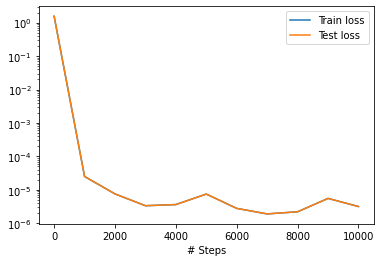

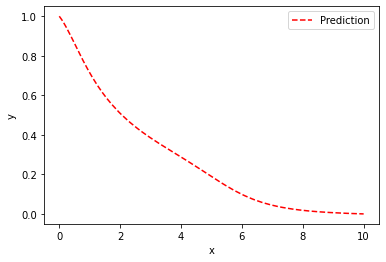

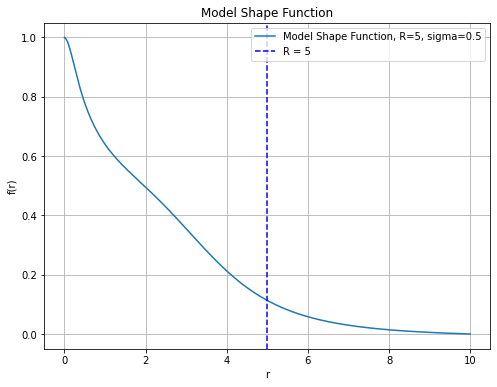

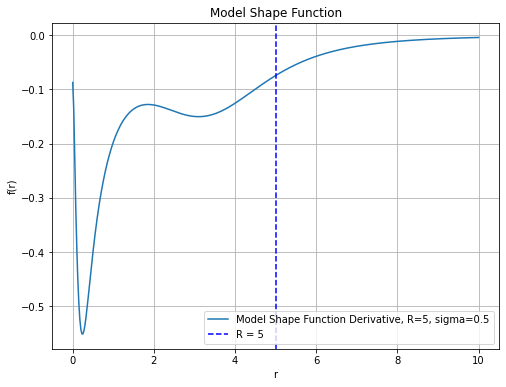

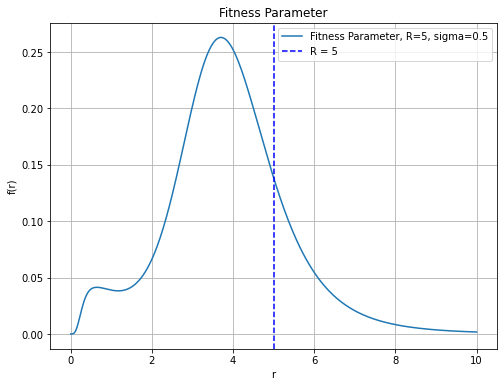

C:\Users\Lyle\AppData\Local\Temp\ipykernel_7680\919593292.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)


Model Total Energy Requirement: 0.7954472727025234
Relative Percent Difference from Alcubierre: 17.692213855934348%


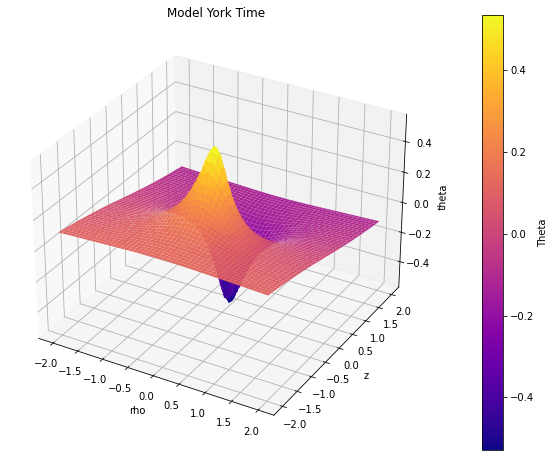

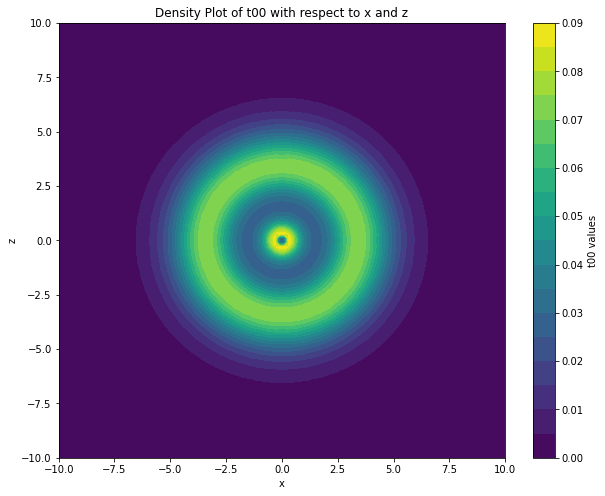

In [236]:


model_0 = generate_evolution_model(100,100,100,2,0.01,10000)

# Your existing code
r_values = np.linspace(0, 10, 400)
f_values = model_0.predict(r_values.reshape(-1, 1)).flatten()

# Create an interpolation function
model_shape_function = interp1d(r_values, f_values, kind='linear', fill_value="extrapolate")


def model_shape_derivative(r):
    epsilon = 1e-7
    derivative = ((model_shape_function(r + epsilon)) - model_shape_function(r - epsilon)) / (2 * epsilon)
    return derivative


def model_fitness_parameter(r):
    return  (r**2)*(model_shape_derivative(r)**2)



# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Model Shape Function, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Model Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_shape_derivative(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Model Shape Function Derivative, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Model Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_fitness_parameter(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Fitness Parameter, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Fitness Parameter')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()




model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)

print("Model Total Energy Requirement: " + str(model_energy_requirement))
print("Relative Percent Difference from Alcubierre: " + str((model_energy_requirement/alcubierre_energy_requirement)*100) + "%")



def plot_alcubierre_york_time(rho, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(rho**2 + z**2)
    derivative = (model_shape_function(r + epsilon) - model_shape_function(r - epsilon)) / (2 * epsilon)
    theta = (z / r) * derivative
    return theta

# Define the range of rho and z values
rho_vals = np.linspace(-2, 2, 200)
z_vals = np.linspace(-2, 2, 200)
rho_mesh, z_mesh = np.meshgrid(rho_vals, z_vals)

# Calculate theta values for each combination of rho and z
theta_mesh = plot_alcubierre_york_time(rho_mesh, z_mesh)

# Create a larger 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a galaxy-themed color map
galaxy_cmap = plt.get_cmap('plasma')

# Plot the surface with the galaxy-themed color map
surface = ax.plot_surface(rho_mesh, z_mesh, theta_mesh, cmap=galaxy_cmap)

# Set labels for the axes
ax.set_xlabel('rho')
ax.set_ylabel('z')
ax.set_zlabel('theta')

# Set a title for the plot
ax.set_title('Model York Time')

# Add color bar
cbar = fig.colorbar(surface, ax=ax, pad=0.1)
cbar.set_label('Theta')

# Show the plot
plt.show()




def plot_alcubierre_eulerian_violation(x, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(x**2 + z**2)
    derivative = (model_shape_function(r + epsilon) - model_shape_function(r - epsilon)) / (2 * epsilon)
    t00 = r * (derivative**2)
    return t00



# Generate a grid of x and z values
x_vals = np.linspace(-10, 10, 100)
z_vals = np.linspace(-10, 10, 100)
X, Z = np.meshgrid(x_vals, z_vals)

# Calculate the t00 values for each combination of x and z
t00_vals = plot_alcubierre_eulerian_violation(X, Z)

# Create a density plot
plt.figure(figsize=(10, 8))
plt.contourf(X, Z, t00_vals, levels=20, cmap='viridis')
plt.colorbar(label='t00 values')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Density Plot of t00 with respect to x and z')
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.049987 s

'compile' took 0.836362 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.49e-03, 1.00e+00, 4.84e+00]    [1.49e-03, 1.00e+00, 4.84e+00]    []  
1000      [2.10e-05, 7.42e-09, 5.22e-09]    [2.10e-05, 7.42e-09, 5.22e-09]    []  

Best model at step 1000:
  train loss: 2.10e-05
  test loss: 2.10e-05
  test metric: []

'train' took 7.985526 s

Epoch Batch 0Completed
Training model...

Step      Train loss                        Test loss                         Test metric
1000      [2.10e-05, 7.42e-09, 5.22e-09]    [2.10e-05, 7.42e-09, 5.22e-09]    []  
2000      [8.84e-06, 1.52e-09, 1.14e-09]    [8.84e-06, 1.52e-09, 1.14e-09]    []  

Best model at step 2000:
  train loss: 8.84e-06
  test loss: 8.84e-06
  test metric: []

'train' took 8.847147 s

Epoch Batch 1Completed
Training model...

Step      Train loss                        

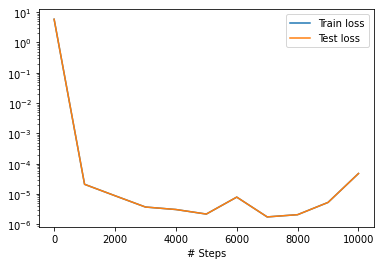

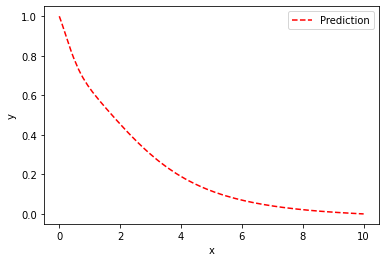

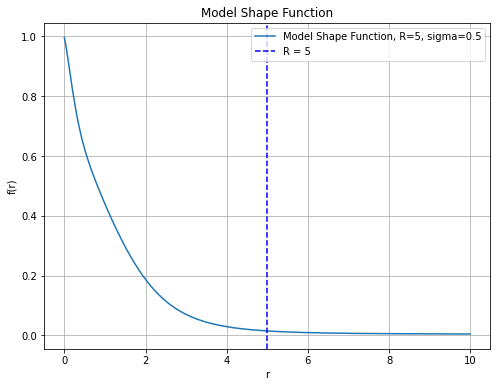

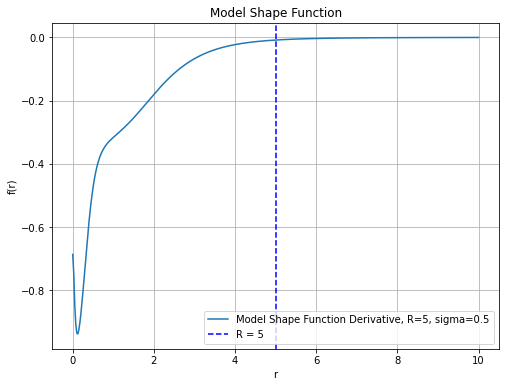

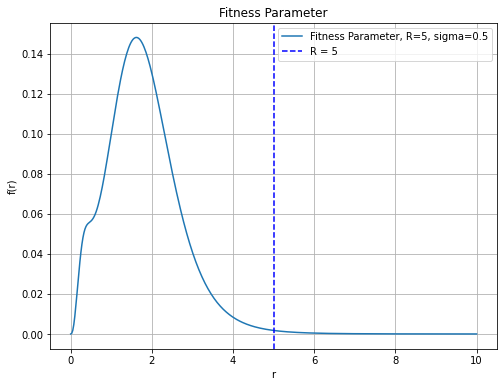

C:\Users\Lyle\AppData\Local\Temp\ipykernel_7680\919593292.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)


Model Total Energy Requirement: 0.2975808664082333
Relative Percent Difference from Alcubierre: 6.6187470981469%


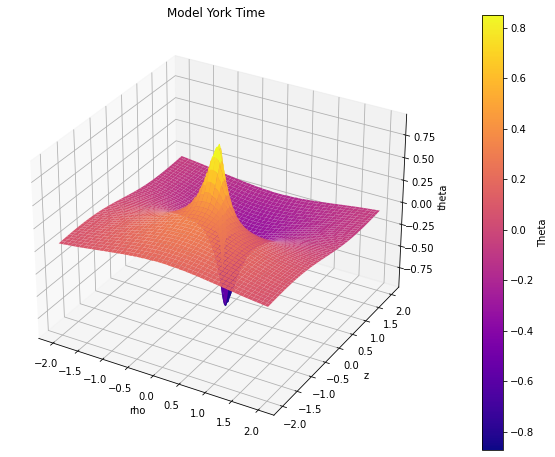

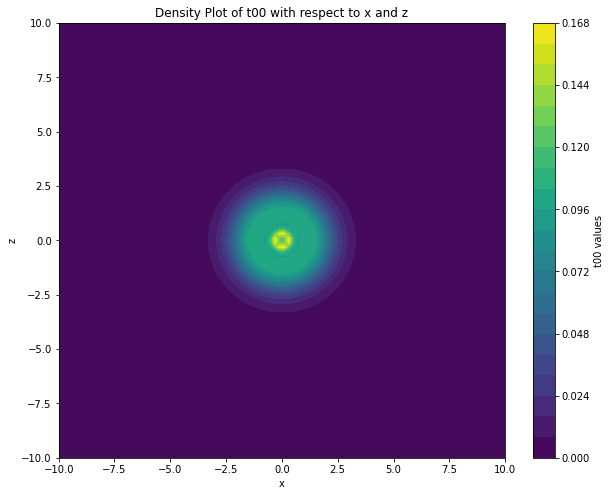

In [258]:


model_0 = generate_evolution_model(100,100,100,2,0.01,10000)

# Your existing code
r_values = np.linspace(0, 10, 400)
f_values = model_0.predict(r_values.reshape(-1, 1)).flatten()

# Create an interpolation function
model_shape_function = interp1d(r_values, f_values, kind='linear', fill_value="extrapolate")


def model_shape_derivative(r):
    epsilon = 1e-7
    derivative = ((model_shape_function(r + epsilon)) - model_shape_function(r - epsilon)) / (2 * epsilon)
    return derivative


def model_fitness_parameter(r):
    return  (r**2)*(model_shape_derivative(r)**2)



# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Model Shape Function, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Model Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_shape_derivative(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Model Shape Function Derivative, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Model Shape Function')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()



# Generate a range of r values
r_values = np.linspace(0, 10, 400)  # Adjust the range as needed
f_values = model_fitness_parameter(r_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, f_values, label='Fitness Parameter, ' + 'R=' + str(R) + ', sigma=' + str(sigma))

plt.axvline(x=5, color='blue', linestyle='--', label='R = '+ str(R))
plt.title('Fitness Parameter')
plt.xlabel('r')
plt.ylabel('f(r)')
plt.legend()
plt.grid(True)
plt.show()




model_energy_requirement, _ = spi.quad(model_fitness_parameter, 0, 10)

print("Model Total Energy Requirement: " + str(model_energy_requirement))
print("Relative Percent Difference from Alcubierre: " + str((model_energy_requirement/alcubierre_energy_requirement)*100) + "%")



def plot_alcubierre_york_time(rho, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(rho**2 + z**2)
    derivative = (model_shape_function(r + epsilon) - model_shape_function(r - epsilon)) / (2 * epsilon)
    theta = (z / r) * derivative
    return theta

# Define the range of rho and z values
rho_vals = np.linspace(-2, 2, 200)
z_vals = np.linspace(-2, 2, 200)
rho_mesh, z_mesh = np.meshgrid(rho_vals, z_vals)

# Calculate theta values for each combination of rho and z
theta_mesh = plot_alcubierre_york_time(rho_mesh, z_mesh)

# Create a larger 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a galaxy-themed color map
galaxy_cmap = plt.get_cmap('plasma')

# Plot the surface with the galaxy-themed color map
surface = ax.plot_surface(rho_mesh, z_mesh, theta_mesh, cmap=galaxy_cmap)

# Set labels for the axes
ax.set_xlabel('rho')
ax.set_ylabel('z')
ax.set_zlabel('theta')

# Set a title for the plot
ax.set_title('Model York Time')

# Add color bar
cbar = fig.colorbar(surface, ax=ax, pad=0.1)
cbar.set_label('Theta')

# Show the plot
plt.show()




def plot_alcubierre_eulerian_violation(x, z, epsilon=1e-7):
    R = 5  # Given value of R
    sigma = 0.5  # Given value of sigma
    
    r = np.sqrt(x**2 + z**2)
    derivative = (model_shape_function(r + epsilon) - model_shape_function(r - epsilon)) / (2 * epsilon)
    t00 = r * (derivative**2)
    return t00



# Generate a grid of x and z values
x_vals = np.linspace(-10, 10, 100)
z_vals = np.linspace(-10, 10, 100)
X, Z = np.meshgrid(x_vals, z_vals)

# Calculate the t00 values for each combination of x and z
t00_vals = plot_alcubierre_eulerian_violation(X, Z)

# Create a density plot
plt.figure(figsize=(10, 8))
plt.contourf(X, Z, t00_vals, levels=20, cmap='viridis')
plt.colorbar(label='t00 values')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Density Plot of t00 with respect to x and z')
plt.show()
